<a href="https://colab.research.google.com/github/Michwynn/London-Airbnb-Analysis---2/blob/main/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configuration and library set-up**

In [ ]:
# set up working directory
import os
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Airbnb_Milestone2

# data manipulation
import pandas as pd
import numpy as np 
import re # regex
pattern = '\w+' # default regex pattern
import random
import string
from collections import Counter, defaultdict
from itertools import chain

# machine learning
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# timeit
from tqdm import tqdm

# data visualisation
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# NLP
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # comment out if already downloaded
stop_words = set(stopwords.words('english'))
nltk.download('punkt')     # comment out if already downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


# supress warnings
import warnings 
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

RANDOM_SEED = 42
fractions = np.array([0.8, 0.1, 0.1])

# unsupervised learning modules

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

from pprint import pprint

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1wUOfFY-ki2nFzneeaTtXLEeMjaSdKrrj/Airbnb_Milestone2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
reviews_df = pd.read_csv('cleaned_df_undersampling.csv', lineterminator = '\n')

In [ ]:
display(reviews_df)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,cleaned_comments,VADER_compound_score,sentiment,review_length,cleaned_comments_nltk
0,210971,210971,227787,3240539,24230882,2014-12-23,23308883,Jun Seok,She prepared a great welcoming for my familys ...,en,she prepared great welcoming familys london tr...,0.98,Positive,58,"[prepared, welcoming, family, trip, christmas,..."
1,22381,22381,24147,377707,8440026,2013-10-30,9438132,Melody,Raimonda was a very wonderful and welcoming ho...,en,raimonda wonderful welcoming host although i g...,0.97,Positive,75,"[raimonda, wonderful, welcoming, host, althoug..."
2,791547,791547,880350,1505411,496355093,2019-07-27,103570150,Mak,I stayed with Alastair and Sara for 3 weeks fo...,en,i stayed alastair sara weeks work related stay...,0.90,Positive,39,"[stayed, alastair, sara, week, work, related, ..."
3,3318,3318,3634,37702403,474483000613537945,2021-10-16,61349706,Pia,I had a pleasant stay with Daniel. I can only ...,en,i pleasant stay daniel i recommend booking,0.70,Positive,16,"[pleasant, daniel, recommend, booking]"
4,62063,62063,66002,50558820,522276589598178355,2021-12-21,85581909,Avdesh,Great place great hosts. Lots of amazing detai...,en,great place great hosts lots amazing details c...,0.97,Positive,74,"[host, lot, detail, comfort, host, everything,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48550,1086825,1086825,1215478,32122892,472187301,2019-06-19,104716150,Safira,She canceled my booking on the day and ive alm...,en,she canceled booking day ive almost arrived pl...,-0.94,Negative,252,"[canceled, booking, day, ive, almost, arrived,..."
48551,1086858,1086858,1215518,32154836,478850156,2019-06-30,265138595,Fiona,"A nice flat in a lovely location, but the room...",en,a nice flat lovely location room smaller descr...,-0.25,Negative,75,"[location, smaller, described, adequately, cle..."
48552,1087181,1087181,1215870,36878239,634871062,2020-07-05,353426098,Courtney,Was very dirty dust and unclean bed sheets,en,was dirty dust unclean bed sheets,-0.49,Negative,8,"[dirty, dust, unclean, bed, sheet]"
48553,1087182,1087182,1215871,36878239,608343112,2020-02-20,8153715,Constance,The appartment is ideally situated. Less than ...,en,the appartment ideally situated less walk edgw...,-0.69,Negative,175,"[appartment, ideally, situated, le, walk, edgw..."


### LDA Using sklearn ###

In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx+1}:")
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
count_vectorizer = TfidfVectorizer(
                        strip_accents='unicode',
                        preprocessor=None,
                        analyzer='word',
                        ngram_range=(1, 2),
                        min_df=10,
                        use_idf=True, smooth_idf=True, 
                        max_features = 5000)

In [ ]:
count_vectorizer.fit(reviews_df['cleaned_comments_nltk'])


TfidfVectorizer(max_features=5000, min_df=10, ngram_range=(1, 2),
                strip_accents='unicode')

In [ ]:
%%time
number_topics = 10
number_words = 10

bag_of_words = count_vectorizer.transform(reviews_df['comments'])

# Create and fit the LDA model
lda = LDA(n_components=number_topics, random_state=RANDOM_SEED, n_jobs=-1, learning_method='online')
lda.fit(bag_of_words)

print_topics(lda, count_vectorizer, number_words)



Topic #1:
nice expected nice place come really back place come back stay great stay

Topic #2:
convenient location everything stay perfect convenient location home exactly described recommend

Topic #3:
canceled automated posting posting automated host canceled mold min walk staircase term alright

Topic #4:
good place website ive convenient place hidden hyde hyde park tin website hidden kensington

Topic #5:
dirty conveniently located conveniently reception would stay staff handy landlord confortable apt

Topic #6:
place great place stay smaller spot great provide dark thanks customer

Topic #7:
stay great london place location us really central definitely close

Topic #8:
not reservation arrival host there us he room didnt check

Topic #9:
great location good great location good location value highly recommended communication place

Topic #10:
not there station close walk london place can location stay
CPU times: user 57.3 s, sys: 5.05 s, total: 1min 2s
Wall time: 2min 11s


### LSA using Gensim ###

------ Converting string to tokens for cleaned comments ------

In [ ]:
def clean_up(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()

    useless_words = nltk.corpus.stopwords.words("english")
    add_words = ['hi', 'im','i','london','stay','flat','room','place','apartment','u','would','really','airbnb','good','nice','great','didnt','lovely','amazing']
    useless_words.extend(add_words) 

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    stem_clean = [word for word in text_stemmed if not word in useless_words]
    final_string = ' '.join(stem_clean)
    
    tokens = nltk.word_tokenize(final_string)

    return tokens

In [ ]:
%%time
reviews_df.drop('cleaned_comments_nltk', axis=1, inplace=True)
reviews_df['cleaned_comments_nltk'] = reviews_df['comments'].apply(clean_up, stem='Lem')
#display(reviews_df.head(5))


CPU times: user 34.1 s, sys: 1.2 s, total: 35.3 s
Wall time: 37.5 s


#### Dividing the dataframe into positive, negative, neutral sentiment

In [ ]:
#Positive sentiment dataframe
positive_df = reviews_df[reviews_df['sentiment']=='Positive']
#Negative sentiment dataframe
negative_df = reviews_df[reviews_df['sentiment']=='Negative']
#Neutral sentiment dataframe
neutral_df = reviews_df[reviews_df['sentiment']=='Neutral']

#### Prepare corpus ####

In [ ]:
def prepare_corpus(doc_clean,sentiment):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(reviews_df['cleaned_comments_nltk'])
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    if sentiment == 'pos':
      doc_term_matrix = [dictionary.doc2bow(doc) for doc in positive_df['cleaned_comments_nltk']]
    elif sentiment == 'neg':
      doc_term_matrix = [dictionary.doc2bow(doc) for doc in negative_df['cleaned_comments_nltk']]
    elif sentiment == 'neu':
      doc_term_matrix = [dictionary.doc2bow(doc) for doc in neutral_df['cleaned_comments_nltk']]
    return dictionary,doc_term_matrix

#### Generate LSA gensim model ####

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words,sentiment):

    dictionary,doc_term_matrix=prepare_corpus(doc_clean,sentiment)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
number_of_topics= 10
words=10

#### Finding the best number of topics for model using coherence score ####

Num Topics = 2  has Coherence Value of 0.4909
Num Topics = 4  has Coherence Value of 0.5237
Num Topics = 6  has Coherence Value of 0.4969
Num Topics = 8  has Coherence Value of 0.4987
Num Topics = 10  has Coherence Value of 0.538
Num Topics = 12  has Coherence Value of 0.4893
Num Topics = 14  has Coherence Value of 0.5004
Num Topics = 16  has Coherence Value of 0.5121
Num Topics = 18  has Coherence Value of 0.5261


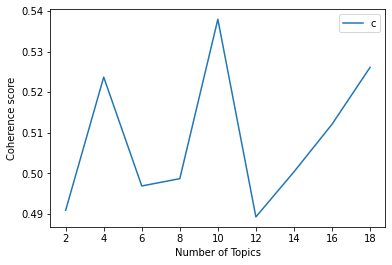

In [ ]:
def plot_graph(doc_clean,start, stop, step,sentiment):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean,sentiment)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    for m, cv in zip(x, coherence_values):
      print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,20,2
plot_graph(reviews_df['cleaned_comments_nltk'],start,stop,step,'pos')

#### Topics for each sentiments

In [ ]:
%%time
# Positive sentiment model
pos_model=create_gensim_lsa_model(positive_df['cleaned_comments_nltk'],number_of_topics,words,'pos')
# Negative sentiment model
neg_model=create_gensim_lsa_model(negative_df['cleaned_comments_nltk'],number_of_topics,words,'neg')
# Neutral sentiment model
neu_model=create_gensim_lsa_model(neutral_df['cleaned_comments_nltk'],number_of_topics,words,'neu')


[(0, '0.292*"location" + 0.265*"host" + 0.256*"clean" + 0.177*"recommend" + 0.175*"comfortable" + 0.172*"station" + 0.160*"well" + 0.156*"walk" + 0.153*"everything" + 0.145*"also"'), (1, '-0.563*"location" + -0.458*"host" + 0.200*"walk" + 0.198*"station" + -0.166*"clean" + 0.150*"also" + -0.147*"recommend" + 0.145*"minute" + -0.121*"perfect" + 0.104*"day"'), (2, '-0.636*"location" + 0.476*"host" + 0.215*"house" + 0.198*"home" + -0.173*"walk" + -0.167*"station" + 0.149*"recommend" + -0.119*"tube" + 0.116*"clean" + -0.110*"minute"'), (3, '-0.814*"clean" + 0.353*"host" + 0.186*"home" + -0.170*"comfortable" + 0.132*"location" + -0.110*"well" + 0.087*"time" + 0.077*"perfect" + -0.071*"everything" + -0.071*"bed"'), (4, '-0.385*"host" + -0.359*"station" + -0.336*"walk" + 0.325*"home" + 0.235*"location" + -0.226*"minute" + -0.196*"tube" + 0.161*"comfortable" + -0.145*"close" + 0.132*"feel"'), (5, '-0.489*"recommend" + 0.367*"host" + -0.260*"home" + -0.254*"house" + -0.235*"highly" + -0.230*"pe

#### Printing Topics for positive reviews



**Topic 0:**, '0.292*"location" + 0.265*"host" + 0.256*"clean" + 0.177*"recommend" + 0.175*"comfortable" + 0.172*"station" + 0.160*"well" + 0.156*"walk" + 0.153*"everything" + 0.145*"also"'

**Topic 1:** '-0.563*"location" + -0.458*"host" + 0.200*"walk" + 0.198*"station" + -0.166*"clean" + 0.150*"also" + -0.147*"recommend" + 0.145*"minute" + -0.121*"perfect" + 0.104*"day"'


**Topic 2:**  '-0.636*"location" + 0.476*"host" + 0.215*"house" + 0.198*"home" + -0.173*"walk" + -0.167*"station" + 0.149*"recommend" + -0.119*"tube" + 0.116*"clean" + -0.110*"minute"'
 

**Topic 3:**  '-0.814*"clean" + 0.353*"host" + 0.186*"home" + -0.170*"comfortable" + 0.132*"location" + -0.110*"well" + 0.087*"time" + 0.077*"perfect" + -0.071*"everything" + -0.071*"bed"'
  

**Topic 4:** '-0.385*"host" + -0.359*"station" + -0.336*"walk" + 0.325*"home" + 0.235*"location" + -0.226*"minute" + -0.196*"tube" + 0.161*"comfortable" + -0.145*"close" + 0.132*"feel"'
  

**Topic 5:**  '-0.489*"recommend" + 0.367*"host" + -0.260*"home" + -0.254*"house" + -0.235*"highly" + -0.230*"perfect" + -0.230*"everything" + 0.156*"bed" + 0.147*"also" + 0.137*"one"'
  

**Topic 6:**  '-0.630*"house" + 0.409*"everything" + 0.255*"recommend" + -0.196*"comfortable" + 0.187*"easy" + 0.175*"need" + -0.163*"location" + 0.163*"well" + -0.155*"home" + -0.132*"station"'
  

**Topic 7:**  '-0.516*"everything" + -0.415*"house" + 0.361*"comfortable" + 0.310*"recommend" + 0.271*"home" + -0.234*"need" + -0.169*"perfect" + 0.163*"highly" + 0.157*"easy" + 0.145*"bed"'
  

**Topic 8:**  '0.418*"home" + -0.399*"recommend" + -0.377*"house" + 0.299*"everything" + 0.208*"comfortable" + -0.198*"well" + 0.198*"walk" + -0.167*"highly" + 0.146*"minute" + 0.141*"perfect"'
  

**Topic 9:**  '0.591*"well" + 0.432*"comfortable" + -0.314*"clean" + -0.238*"time" + 0.187*"everything" + 0.164*"bed" + -0.132*"also" + 0.127*"house" + 0.111*"equipped" + -0.111*"get"'


#### Printing Topics for negative reviews



**Topic 0:**  '0.276*"host" + 0.213*"day" + 0.205*"one" + 0.176*"night" + 0.171*"time" + 0.151*"also" + 0.145*"door" + 0.143*"bed" + 0.135*"get" + 0.134*"bathroom"'
 
**Topic 1:**  '0.711*"host" + -0.246*"bed" + -0.211*"bathroom" + -0.160*"shower" + -0.149*"dirty" + -0.139*"kitchen" + -0.114*"clean" + -0.113*"location" + -0.111*"floor" + 0.107*"day"'

**Topic 2:**  '-0.591*"host" + 0.327*"day" + -0.242*"bed" + 0.197*"time" + -0.166*"dirty" + -0.165*"bathroom" + 0.154*"key" + 0.133*"check" + 0.126*"told" + -0.121*"kitchen"'

**Topic 3:**  '0.550*"house" + -0.459*"night" + -0.213*"bed" + 0.196*"dirty" + 0.184*"door" + 0.176*"bathroom" + 0.175*"kitchen" + -0.140*"location" + -0.140*"day" + -0.136*"water"'
 
**Topic 4:**  '0.417*"water" + -0.387*"bed" + 0.362*"shower" + -0.345*"night" + 0.272*"day" + 0.218*"hot" + 0.175*"bathroom" + 0.157*"issue" + 0.126*"problem" + -0.119*"house"'
 
**Topic 5:**  '-0.527*"door" + 0.478*"day" + -0.250*"key" + 0.240*"house" + 0.196*"bed" + -0.183*"get" + -0.149*"lock" + -0.144*"open" + 0.119*"dirty" + 0.110*"even"'

**Topic 6:**  '-0.482*"night" + -0.377*"house" + 0.299*"property" + -0.260*"door" + 0.251*"bed" + 0.214*"check" + 0.173*"key" + -0.146*"water" + 0.144*"dirty" + 0.122*"location"'
  
**Topic 7:**  '0.411*"location" + -0.311*"door" + 0.305*"house" + 0.204*"time" + 0.188*"check" + -0.184*"one" + -0.184*"day" + -0.182*"dirty" + -0.159*"property" + 0.148*"also"'
  
**Topic 8:**  '-0.765*"one" + -0.307*"property" + 0.239*"door" + 0.172*"bed" + 0.160*"dirty" + 0.156*"shower" + -0.099*"two" + 0.096*"get" + -0.094*"issue" + -0.091*"bedroom"'
  
**Topic 9:**  '-0.486*"day" + 0.338*"shower" + 0.338*"water" + 0.217*"bed" + 0.191*"house" + -0.175*"location" + 0.163*"hot" + -0.157*"kitchen" + 0.156*"key" + -0.152*"door"'
 



#### Printing Topics for neutral reviews



**Topic 0:**  '0.382*"day" + 0.380*"arrival" + 0.380*"reservation" + 0.380*"canceled" + 0.379*"automated" + 0.379*"posting" + 0.367*"host" + 0.001*"location" + 0.001*"one" + 0.001*"time"'
 
**Topic 1:**  '-0.429*"location" + -0.221*"close" + -0.213*"station" + -0.179*"one" + -0.168*"convenient" + -0.150*"host" + -0.147*"walk" + -0.147*"bed" + -0.146*"need" + -0.146*"night"'

**Topic 2:**  '-0.486*"location" + -0.319*"convenient" + -0.267*"close" + -0.225*"station" + 0.214*"one" + 0.150*"time" + 0.136*"bed" + 0.130*"property" + 0.129*"night" + -0.126*"tube"'

**Topic 3:**  '-0.640*"location" + 0.469*"close" + 0.394*"station" + 0.184*"walk" + 0.169*"tube" + 0.121*"minute" + 0.115*"bus" + -0.111*"convenient" + 0.097*"train" + -0.092*"host"'

**Topic 4:**  '-0.882*"host" + 0.217*"day" + 0.129*"posting" + 0.127*"automated" + 0.127*"canceled" + 0.126*"arrival" + 0.123*"reservation" + 0.108*"location" + -0.075*"need" + 0.062*"one"'
  
**Topic 5:**  '0.802*"everything" + 0.454*"need" + 0.156*"needed" + -0.142*"station" + -0.111*"close" + -0.087*"host" + -0.077*"one" + 0.071*"short" + 0.071*"home" + -0.065*"bed"'
 
**Topic 6:**  '-0.506*"close" + 0.291*"walk" + 0.223*"bed" + -0.223*"property" + -0.173*"time" + 0.170*"minute" + -0.167*"lock" + -0.164*"call" + -0.145*"back" + 0.126*"bathroom"'
  
**Topic 7:**  '-0.498*"convenient" + 0.483*"close" + -0.239*"walk" + -0.228*"station" + -0.217*"minute" + 0.165*"bed" + 0.156*"location" + -0.144*"property" + -0.112*"time" + -0.110*"lock"'
  
**Topic 8:**  '-0.725*"convenient" + 0.285*"location" + 0.249*"station" + 0.210*"walk" + 0.176*"minute" + -0.149*"bed" + -0.126*"night" + -0.120*"close" + -0.107*"one" + 0.102*"property"'
 
**Topic 9:**  '-0.483*"home" + -0.342*"night" + 0.335*"bed" + 0.316*"one" + 0.151*"towel" + 0.150*"property" + 0.149*"need" + -0.145*"check" + -0.135*"time" + 0.127*"provided"'

#### Visualizing the topcis for positive topics ####

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def visual_topics(model):
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

  cloud = WordCloud(stopwords=stop_words,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=10,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

  topics = model.show_topics(formatted=False)

  fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      cloud.fit_words(dict(model.show_topic(i, 200)))
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')


  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.show()

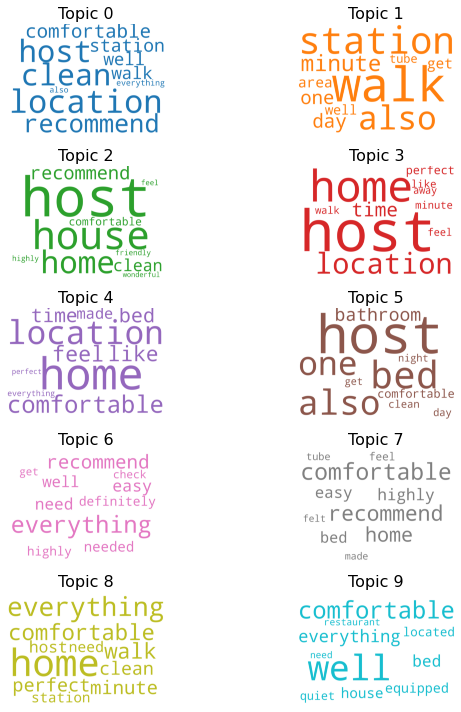

In [ ]:
visual_topics(pos_model)

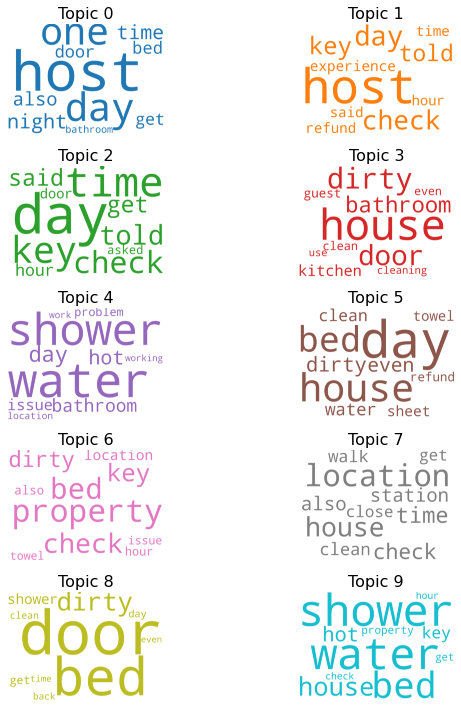

In [ ]:
visual_topics(neg_model)

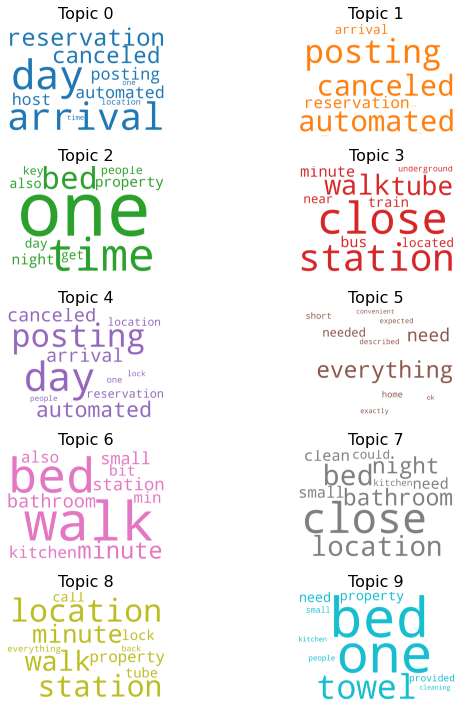

In [ ]:
visual_topics(neu_model)

### LDA using Gensim ###

In [ ]:
def lda_gen(clean_data):
  # Making dictionary
  dictionary = corpora.Dictionary(clean_data)
  # Remove extremes
  dictionary.filter_extremes(no_below=2, no_above=0.5)
  # Making corpus
  corpus = [dictionary.doc2bow(text) for text in clean_data]
  # Making model
  num_topics = 8
  chunksize = 2000
  passes = 20
  iterations = 400
  eval_every = None

  temp = dictionary[0]
  id2word = dictionary.id2token

  model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=num_topics,
      passes=passes,
      eval_every=eval_every
  )
  return model
 

#### Printing the topics ####

In [ ]:
def print_topics(sentiment):
  if sentiment == 'pos':
    dictionary = corpora.Dictionary(positive_df['cleaned_comments_nltk'])
    corpus = [dictionary.doc2bow(text) for text in positive_df['cleaned_comments_nltk']]
    top_topics = lda_gen(positive_df['cleaned_comments_nltk']).top_topics(corpus)
  elif sentiment == 'neg':
    dictionary = corpora.Dictionary(negative_df['cleaned_comments_nltk'])
    corpus = [dictionary.doc2bow(text) for text in negative_df['cleaned_comments_nltk']]
    top_topics = lda_gen(negative_df['cleaned_comments_nltk']).top_topics(corpus)
  elif sentiment == 'neu':
    dictionary = corpora.Dictionary(neutral_df['cleaned_comments_nltk'])
    corpus = [dictionary.doc2bow(text) for text in neutral_df['cleaned_comments_nltk']]
    top_topics = lda_gen(neutral_df['cleaned_comments_nltk']).top_topics(corpus)
  pprint(top_topics)


In [ ]:
print("Printing positive topcis")
print("==========================")
print_topics('pos')
print("Printing negative topcis")
print("==========================")
print_topics('neg')
print("Printing neutral topcis")
print("==========================")
print_topics('neu')

Printing positive topcis
[([(0.05252829, 'location'),
   (0.044426523, 'host'),
   (0.04326134, 'clean'),
   (0.029728001, 'recommend'),
   (0.02424565, 'comfortable'),
   (0.022681613, 'everything'),
   (0.021170018, 'perfect'),
   (0.018104555, 'definitely'),
   (0.017249942, 'house'),
   (0.017248543, 'easy'),
   (0.016512312, 'helpful'),
   (0.014121417, 'well'),
   (0.014104583, 'quiet'),
   (0.013939275, 'friendly'),
   (0.013470013, 'highly'),
   (0.011829992, 'area'),
   (0.011663489, 'need'),
   (0.010987009, 'communication'),
   (0.010740598, 'wonderful'),
   (0.0102831805, 'super')],
  -6.7139605756167375),
 ([(0.023383895, 'day'),
   (0.016561316, 'even'),
   (0.013435729, 'work'),
   (0.013118259, 'also'),
   (0.013097657, 'time'),
   (0.011936487, 'could'),
   (0.00956732, 'night'),
   (0.008928696, 'thing'),
   (0.0088521475, 'arrival'),
   (0.008589748, 'one'),
   (0.008105612, 'morning'),
   (0.008070725, 'early'),
   (0.0077855936, 'tea'),
   (0.0076411134, 'left'),
 

In [ ]:
def lda_vis(model,clean_data):
  !pip install pyLDAvis
  import pickle
  import pyLDAvis.gensim_models as gensimvis
  import pyLDAvis
  if clean_data =='pos':
    clean_data = positive_df['cleaned_comments_nltk']
    dictionary = corpora.Dictionary(clean_data)
    # Remove extremes
    dictionary.filter_extremes(no_below=2, no_above=0.5)
    # Making corpus
    corpus = [dictionary.doc2bow(text) for text in clean_data]
    lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
    pyLDAvis.save_html(lda_visualization, 'LDA visualizations_positive.html')
  elif clean_data =='neg':
    clean_data = negative_df['cleaned_comments_nltk']
    dictionary = corpora.Dictionary(clean_data)
    # Remove extremes
    dictionary.filter_extremes(no_below=2, no_above=0.5)
    # Making corpus
    corpus = [dictionary.doc2bow(text) for text in clean_data]
    lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
    pyLDAvis.save_html(lda_visualization, 'LDA visualizations_negative.html')
  elif clean_data =='neu':
    clean_data = neutral_df['cleaned_comments_nltk']
    dictionary = corpora.Dictionary(clean_data)
    # Remove extremes
    dictionary.filter_extremes(no_below=2, no_above=0.5)
    # Making corpus
    corpus = [dictionary.doc2bow(text) for text in clean_data]
    lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
    pyLDAvis.save_html(lda_visualization, 'LDA visualizations_neutral.html')

In [ ]:
lda_vis(lda_gen(positive_df['cleaned_comments_nltk']),'pos')
lda_vis(lda_gen(negative_df['cleaned_comments_nltk']),'neg')
lda_vis(lda_gen(neutral_df['cleaned_comments_nltk']),'neu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
